As the name says, all I am doing here is cleaning the data - more specifically, replacing missing values in the training data. The result should be the starting point for further exploration and/or feature engineering. In order to build the actual model, further steps will have to be taken.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [2]:
houseprice=pd.read_csv('../input/train.csv')
houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


You can already see that there are NaNs in some columns. So let's see where exactly and how many

In [3]:
# To check how many columns have missing values - this can be repeated to see the progress made
def show_missing():
    missing = houseprice.columns[houseprice.isnull().any()].tolist()
    return missing

In [4]:
houseprice[show_missing()].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## Data Cleaning Plan
Let's look at these variables in the data dictionary:

* LotFrontage: Linear feet of street connected to property. I can't imagine that this would be 0 (as this would be a property without access), so either impute mean, or maybe see if there's a correlation with LotArea (like square root?).

* Alley: Type of alley access to property -> Many missing values, I would presume that these properties just don't have an alley access.

* MasVnrType/MasVnrArea -> both have 8 values missing, I presume they are the same ones. Either set as "None"/0 or use most frequent value/median.

* Bsmt... Variables: A  number of variables in connection with the basement. About the same number of missing values. However, there are two basement-related variables without missing values "BsmtFinSF1" and "BsmtFinSF2" - look at those and then decide what to do with the missing values.

* Electrical: Just one missing value - here just impute most frequent one.

* FireplaceQu: I assume the properties with missing values just don't have a fireplace. There's also the variable Fireplaces (without missing values) - check this and then decide.

* Garage ... Variables: 81 missing in these columns. However, there are some Garage-related variables without missing values: GarageCars, GarageArea - check these and then decide.

* PoolQC - probably no pool - but check against PoolArea (which has no missing values).

* Fence: Many missing values - probably no fence, just impute 'None'

* MiscFeature: Assuming none - probably no special features, just impute 'None'

In [5]:
# Looking at categorical values
def cat_exploration(column):
    return houseprice[column].value_counts()

In [6]:
# Imputing the missing values
def cat_imputation(column, value):
    houseprice.loc[houseprice[column].isnull(),column] = value

### LotFrontage/LotArea
A number of values are missing and one possibility would be to just impute the mean. However, there should actually be a correlation with LotArea, which has no missing values.

In [7]:
# check correlation with LotArea
houseprice['LotFrontage'].corr(houseprice['LotArea'])

0.42609501877180816

Ok, that's not great. I we assume that most lots are rectangular, using the square root might be an improvement. 

In [8]:
# improvement - and good enough for now
houseprice['SqrtLotArea']=np.sqrt(houseprice['LotArea'])
houseprice['LotFrontage'].corr(houseprice['SqrtLotArea'])

0.6020022167939364

Populating the interactive namespace from numpy and matplotlib


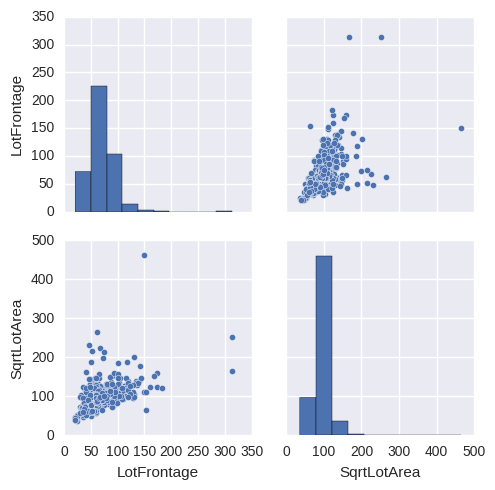

In [9]:
import seaborn as sns
%pylab inline
sns.pairplot(houseprice[['LotFrontage','SqrtLotArea']].dropna())

In [10]:
cond = houseprice['LotFrontage'].isnull()
houseprice.LotFrontage[cond]=houseprice.SqrtLotArea[cond]

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
# This column is not needed anymore
del houseprice['SqrtLotArea']

### Alley

In [12]:
cat_exploration('Alley')

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [13]:
# I assume empty fields here mean no alley access
cat_imputation('Alley','None')

### MasVnr

In [14]:
houseprice[['MasVnrType','MasVnrArea']][houseprice['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


So the missing values for the "MasVnr..." Variables are in the same rows.

In [15]:
cat_exploration('MasVnrType')

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Since "None" is the most frequent value, I will impute "None" for the Type, and 0.0 for the area.

In [16]:
cat_imputation('MasVnrType', 'None')
cat_imputation('MasVnrArea', 0.0)

### Basement

In [17]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
houseprice[basement_cols][houseprice['BsmtQual'].isnull()==True]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0
342,NaN,NaN,NaN,NaN,NaN,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0
371,NaN,NaN,NaN,NaN,NaN,0,0


So in the cases where the categorical variables are NaN, the numerical ones are 0. Which means there's no basement, so the categorical ones should also be set to "None".

In [18]:
for cols in basement_cols:
    if 'FinSF'not in cols:
        cat_imputation(cols,'None')

### Electrical

In [19]:
cat_exploration('Electrical')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [20]:
# Impute most frequent value
cat_imputation('Electrical','SBrkr')

### Fireplace

In [21]:
cat_exploration('FireplaceQu')

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

I would assume that the 690 just don't have a fireplace. Let's check:

In [22]:
houseprice['Fireplaces'][houseprice['FireplaceQu'].isnull()==True].describe()

count    690.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Fireplaces, dtype: float64

In [23]:
cat_imputation('FireplaceQu','None')

In [24]:
pd.crosstab(houseprice.Fireplaces, houseprice.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


### Garages

In [25]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
houseprice[garage_cols][houseprice['GarageType'].isnull()==True]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


In [26]:
#Garage Imputation
for cols in garage_cols:
    if houseprice[cols].dtype==np.object:
        cat_imputation(cols,'None')
    else:
        cat_imputation(cols, 0)

### Pool

In [27]:
cat_exploration('PoolQC')

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Many missing values - are they all without a pool?

In [28]:
houseprice['PoolArea'][houseprice['PoolQC'].isnull()==True].describe()

count    1453.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: PoolArea, dtype: float64

Yes, seems like it - if PoolQC is empty, PoolArea is 0

In [29]:
cat_imputation('PoolQC', 'None')

### Fence

In [30]:
cat_imputation('Fence', 'None')

### MiscFeature

In [31]:
cat_imputation('MiscFeature', 'None')

### Are we done?

In [32]:
houseprice[show_missing()].isnull().sum()

Series([], dtype: float64)

Yes, all missing values are gone!